<a href="https://colab.research.google.com/github/khp53/EssenceExtract---Summarize-a-long-article-using-BART/blob/main/EssenceExtract_Summarize_a_long_article_using_BART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
!pip install wordcloud

In [ ]:
!pip install Counter

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from datasets import load_dataset
import itertools
from collections import Counter

In [ ]:
dataset = load_dataset("cnn_dailymail", '3.0.0')

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [ ]:
print(dataset['train'][:3])

{'article': ['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office cha

In [ ]:
article_lengths = [len(entry['article']) for entry in dataset['train']]
summary_lengths = [len(entry['highlights']) for entry in dataset['train']]

In [ ]:
# Calculate and print average lengths
print("Average length of articles:", np.mean(article_lengths))
print("Average length of summaries:", np.mean(summary_lengths))

Average length of articles: 4033.6617220397543
Average length of summaries: 294.7703900554834


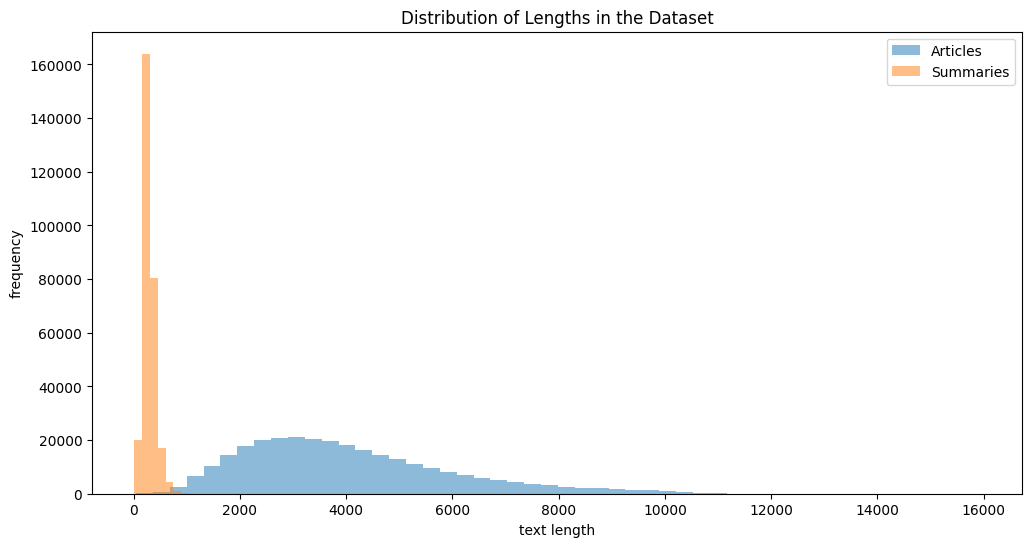

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(article_lengths, bins=50, alpha=0.5, label='Articles')
plt.hist(summary_lengths, bins=50, alpha=0.5, label='Summaries')
plt.title('Distribution of Lengths in the Dataset')
plt.xlabel('text length')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [ ]:
words = (word for entry in dataset['train']['article'] for word in entry.split())

word_counts = Counter(words) # counter libray was used for this

print(word_counts.most_common(10))

[('the', 9791515), ('to', 5332131), ('of', 4554342), ('a', 4487198), ('and', 4480885), ('in', 3825318), ('.', 3071328), ('was', 1884632), ('for', 1779885), ('that', 1717024)]


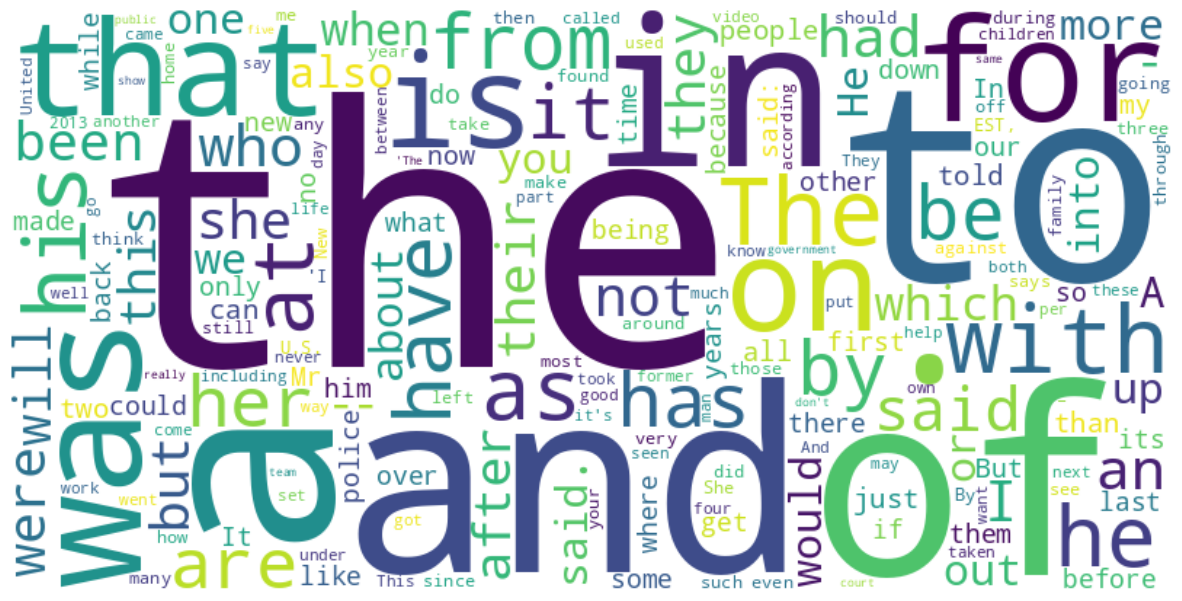

In [ ]:
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(word_counts)
# word cloud library was used for this
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install rouge-score==0.1.2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback
from rouge_score import rouge_scorer

dataset = load_dataset("cnn_dailymail", '3.0.0')
print(dataset)

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')


def preprocess_data(examples):
    inputs = [doc for doc in examples['article']]

    # Hyperparameters: max_length=1024: Maximum length of the input sequences during tokenization. This limits the number of tokens in the input articles.
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")

    # Prepare labels
    with tokenizer.as_target_tokenizer():
        # Hyperparameters: max_length=128: Maximum length of the target sequences during tokenization. This limits the number of tokens in the target summaries.
        labels = tokenizer(examples['highlights'], max_length=32, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_data, batched=True, batch_size=1024)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


1. Token Length Distribution:

This visualization helps in understanding the distribution of token lengths after tokenization, which can be useful for setting appropriate maximum sequence lengths for your model.

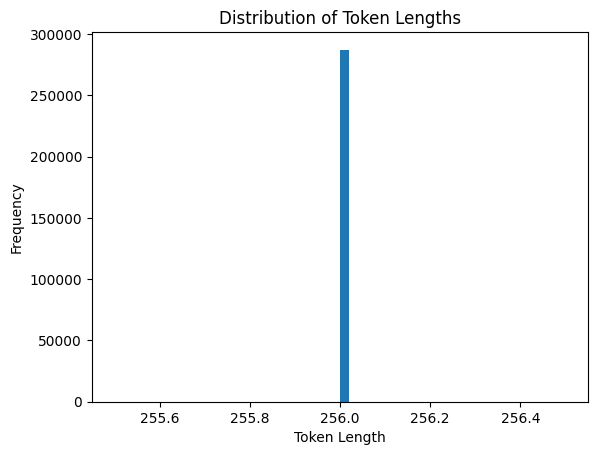

In [ ]:
import matplotlib.pyplot as plt

token_lengths = [len(example['input_ids']) for example in tokenized_datasets['train']]
plt.hist(token_lengths, bins=50)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

2. Attention Mask Visualization:

Attention masks tell the model which tokens to attend to and which to ignore (usually padding tokens). Visualizing them can help understand how the model is focusing.

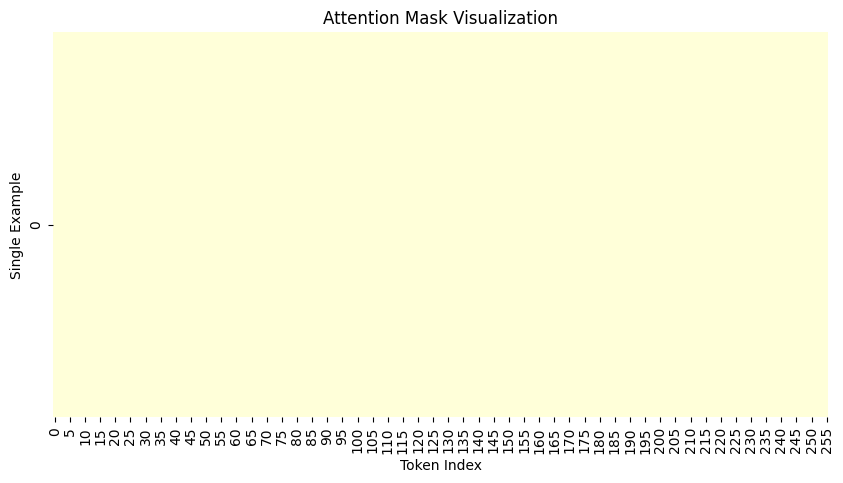

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

example = tokenized_datasets['train'][10]
attention_mask = np.array(example['attention_mask'])

# Reshape the attention mask to a 2D array
attention_mask = attention_mask.reshape(1, -1)  # Reshape to (1, sequence_length)

# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(attention_mask, annot=False, cmap="YlGnBu", cbar=False)
plt.xlabel('Token Index')
plt.ylabel('Single Example')
plt.title('Attention Mask Visualization')
plt.show()

In [ ]:
!pip install tensorboard

In [ ]:
small_train_dataset = tokenized_datasets["train"].select(range(500))
small_test_dataset = tokenized_datasets["test"].select(range(500))
small_val_dataset = tokenized_datasets["validation"].select(range(500))

# Bidirectional and Auto-Regressive Transformers model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print(x)
# else:
#     print("MPS device not found")

# model.to(mps_device)
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model checkpoints
    num_train_epochs=1,              # total number of training epochs - model hyperparameter
    per_device_train_batch_size=8,   # batch size per device during training - model hyperparameter
    per_device_eval_batch_size=8,    # batch size for evaluation - model hyperparameter
    fp16=True,                       # use mixed precision training - model hyperparameter
    warmup_steps=100,                # number of warmup steps for learning rate scheduler - model hyperparameter
    weight_decay=0.01,               # strength of weight decay - model hyperparameter
    logging_dir='./logs',            # directory for storing logs - model hyperparameter
    logging_steps=5,                # log & save weights each logging_steps - model hyperparameter
    evaluation_strategy="steps",     # evaluate each `logging_steps` - model hyperparameter
    eval_steps=10,  # Evaluate every 100 steps
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',  # Choose an appropriate metric
    report_to="tensorboard"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Huggingface Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=small_train_dataset,         # training dataset
    eval_dataset=small_val_dataset,     # evaluation dataset
    callbacks=[TensorBoardCallback()]
)

# Start training
trainer.train()

test_results = trainer.evaluate(small_test_dataset)
print(test_results)

In [ ]:
steps = [10, 20, 30, 40, 50, 60]
validation_losses = [3.31, 2.91, 2.63, 2.46, 2.39, 2.39]  # Corresponding losses

plt.plot(steps, validation_losses, marker='o')
plt.xlabel('Steps')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Different Steps While Training')
plt.show()

In [ ]:
steps = [10, 20, 30, 40, 50, 60]
trainning_losses = [3.15, 2.54, 2.13, 2.02, 2.03, 1.65]  # Corresponding losses

plt.plot(steps, validation_losses, marker='o')
plt.xlabel('Steps')
plt.ylabel('Trainning Loss')
plt.title('Trainning Loss Over Different Steps While Training')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

data = {'Eval Loss': 2.243393659591675,

        'Eval Samples/Second': 0.51,
        'Eval Steps/Second': 0.064,
        'Epoch': 1.0}

metrics = list(data.keys())
values = list(data.values())

plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# Load the trained model and tokenizer
# model_path = './results/checkpoint-60'
# model = BartForConditionalGeneration.from_pretrained(model_path)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [ ]:
# Function to generate summaries
def generate_summary(text):
    inputs = tokenizer(text, max_length=256, return_tensors='pt', truncation=True, padding=True).to('cuda')
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=64, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [ ]:
model.to('cuda')
# Calculate ROUGE scores for the test dataset
rouge_scores = []
for i, example in enumerate(tokenized_datasets["test"]):
    if i >= 500:
        break  # Stop after processing 500 examples
    article = example['article']
    reference_summary = example['highlights']
    generated_summary = generate_summary(article)
    scores = scorer.score(reference_summary, generated_summary)
    rouge_scores.append(scores)



In [ ]:
import matplotlib.pyplot as plt

# Extract ROUGE-1, ROUGE-2, and ROUGE-L scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the scores
ax.plot(rouge1_scores, label='ROUGE-1')
ax.plot(rouge2_scores, label='ROUGE-2')
ax.plot(rougeL_scores, label='ROUGE-L')

# Set labels and title
ax.set_xlabel('Sample Index')
ax.set_ylabel('F1 Score')
ax.set_title('ROUGE Scores for Generated Summaries')
ax.legend()

# Display the plot
plt.show()

# Calculate and print average scores
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print("Average ROUGE-1 F1 Score:", avg_rouge1)
print("Average ROUGE-2 F1 Score:", avg_rouge2)
print("Average ROUGE-L F1 Score:", avg_rougeL)

In [ ]:
# import torch.onnx

# # ... (Load your trained PyTorch model)

# # Create a dummy input tensor with the correct shape
# dummy_input = torch.randn(1, 1024)  # Adjust the shape (1, 1024) based on your model's input requirements

# # Export the model to ONNX format
# torch.onnx.export(model, dummy_input, "model.onnx", verbose=True)

Compare with PEGASUS Model

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

In [ ]:
model_name = "google/pegasus-cnn_dailymail"
pegasus_tokenizer = PegasusTokenizer.from_pretrained(model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(model_name).to('cuda')

In [ ]:
def generate_summary(text, model_name="bart"):
    if model_name == "bart":
        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to('cuda')
    elif model_name == "pegasus":
        tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
        model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-cnn_dailymail").to('cuda')
    else:
        raise ValueError("Invalid model name. Choose 'bart' or 'pegasus'.")

    inputs = tokenizer(text, max_length=256, return_tensors='pt', truncation=True, padding=True).to('cuda')
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=64, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
pegasus_rouge_scores = []
for i, example in enumerate(tokenized_datasets["test"]):
    if i >= 500:
        break
    article = example['article']
    reference_summary = example['highlights']
    generated_summary = generate_summary(article, model_name="pegasus")
    scores = scorer.score(reference_summary, generated_summary)
    pegasus_rouge_scores.append(scores)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pegasus_rouge1_1 = [score['rouge1'].fmeasure for score in pegasus_rouge_scores]
pegasus_rouge2_1 = [score['rouge2'].fmeasure for score in pegasus_rouge_scores]
pegasus_rougeL_1 = [score['rougeL'].fmeasure for score in pegasus_rouge_scores]

fig2, ax2 = plt.subplots()
ax2.plot(pegasus_rouge1, label='ROUGE-1')
ax2.plot(pegasus_rouge2, label='ROUGE-2')
ax2.plot(pegasus_rougeL, label='ROUGE-L')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('F1 Score')
ax2.set_title('PEGASUS ROUGE Scores')
ax2.legend()
plt.show()


# Calculate average scores
bart_rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
bart_rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
bart_rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

pegasus_rouge1 = np.mean([score['rouge1'].fmeasure for score in pegasus_rouge_scores])
pegasus_rouge2 = np.mean([score['rouge2'].fmeasure for score in pegasus_rouge_scores])
pegasus_rougeL = np.mean([score['rougeL'].fmeasure for score in pegasus_rouge_scores])

# Data for plotting
models = ['BART', 'PEGASUS']
rouge1 = [bart_rouge1, pegasus_rouge1]
rouge2 = [bart_rouge2, pegasus_rouge2]
rougeL = [bart_rougeL, pegasus_rougeL]

# Create bar chart
fig, ax = plt.subplots()
bar_width = 0.25
index = np.arange(len(models))

ax.bar(index, rouge1, bar_width, label='ROUGE-1')
ax.bar(index + bar_width, rouge2, bar_width, label='ROUGE-2')
ax.bar(index + 2 * bar_width, rougeL, bar_width, label='ROUGE-L')

ax.set_xlabel('Models')
ax.set_ylabel('Average F1 Score')
ax.set_title('Comparison of ROUGE Scores')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models)
ax.legend()

plt.show()